# Data basic exploration

In [5]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor

In [9]:
# Data_looking.ipynb

# Import necessary libraries

# Load the datasets
stores = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/stores.csv')
features = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/features.csv')
train = pd.read_csv('https://raw.githubusercontent.com/PietroWei/Global-Sales-Analysis-and-Forecasting/refs/heads/main/data/train.csv')



# Merge the datasets on 'Store' and 'Date'
merged_df = pd.merge(train, features, on=['Store', 'Date'])
merged_df = pd.merge(merged_df, stores, on='Store')

# Convert the 'Date' column to the format dd/mm/yyyy
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Check if IsHoliday_x and IsHoliday_y are equal, if not set to NaN
merged_df['IsHoliday'] = merged_df.apply(lambda row: row['IsHoliday_x'] if row['IsHoliday_x'] == row['IsHoliday_y'] else pd.NA, axis=1)

# Remove IsHoliday_x and IsHoliday_y columns
merged_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'], inplace=True)

# Convert 'IsHoliday' from boolean to 0 or 1 (with NaN considered as 0)
merged_df['IsHoliday'] = merged_df['IsHoliday'].fillna(False).astype(int)

# Map 'Type' from 'A', 'B', 'C' to 1, 2, 3 respectively
merged_df['Type'] = merged_df['Type'].map({'A': 1, 'B': 2, 'C': 3})

# Display the first few rows of the merged dataframe to confirm changes
merged_df.head()


,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,0
1,1,1,2010-02-12,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,151315,1
2,1,1,2010-02-19,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,1,151315,0
3,1,1,2010-02-26,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,1,151315,0
4,1,1,2010-03-05,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,1,151315,0


## Dealing with NaN values

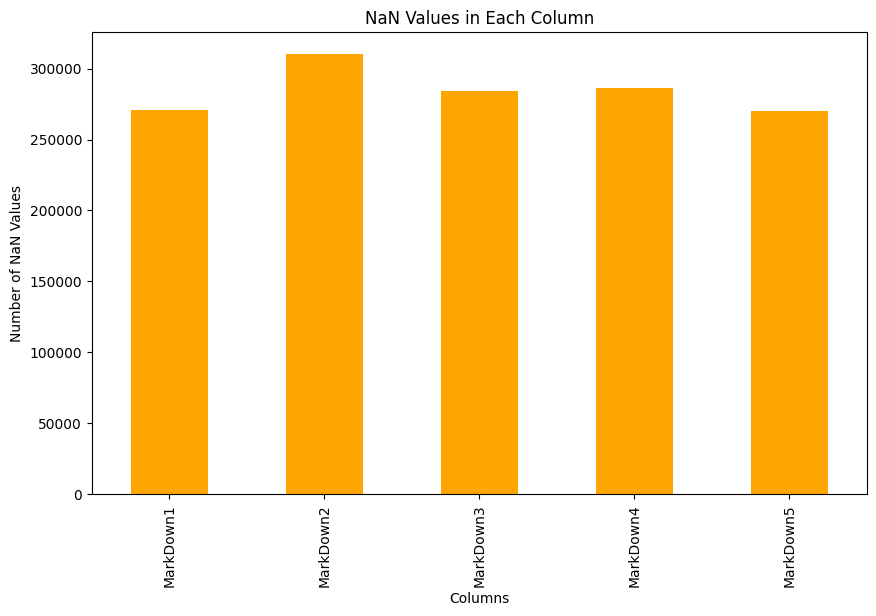

In [10]:
# Plotting the NaN values
plt.figure(figsize=(10, 6))
nan_values = merged_df.isna().sum()
nan_values = nan_values[nan_values > 0]
nan_values.plot(kind='bar', color='orange')
plt.title('NaN Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.show()

# Replace the NaN values in markdown with 0
merged_df = merged_df.fillna(0)

## Basic exploration

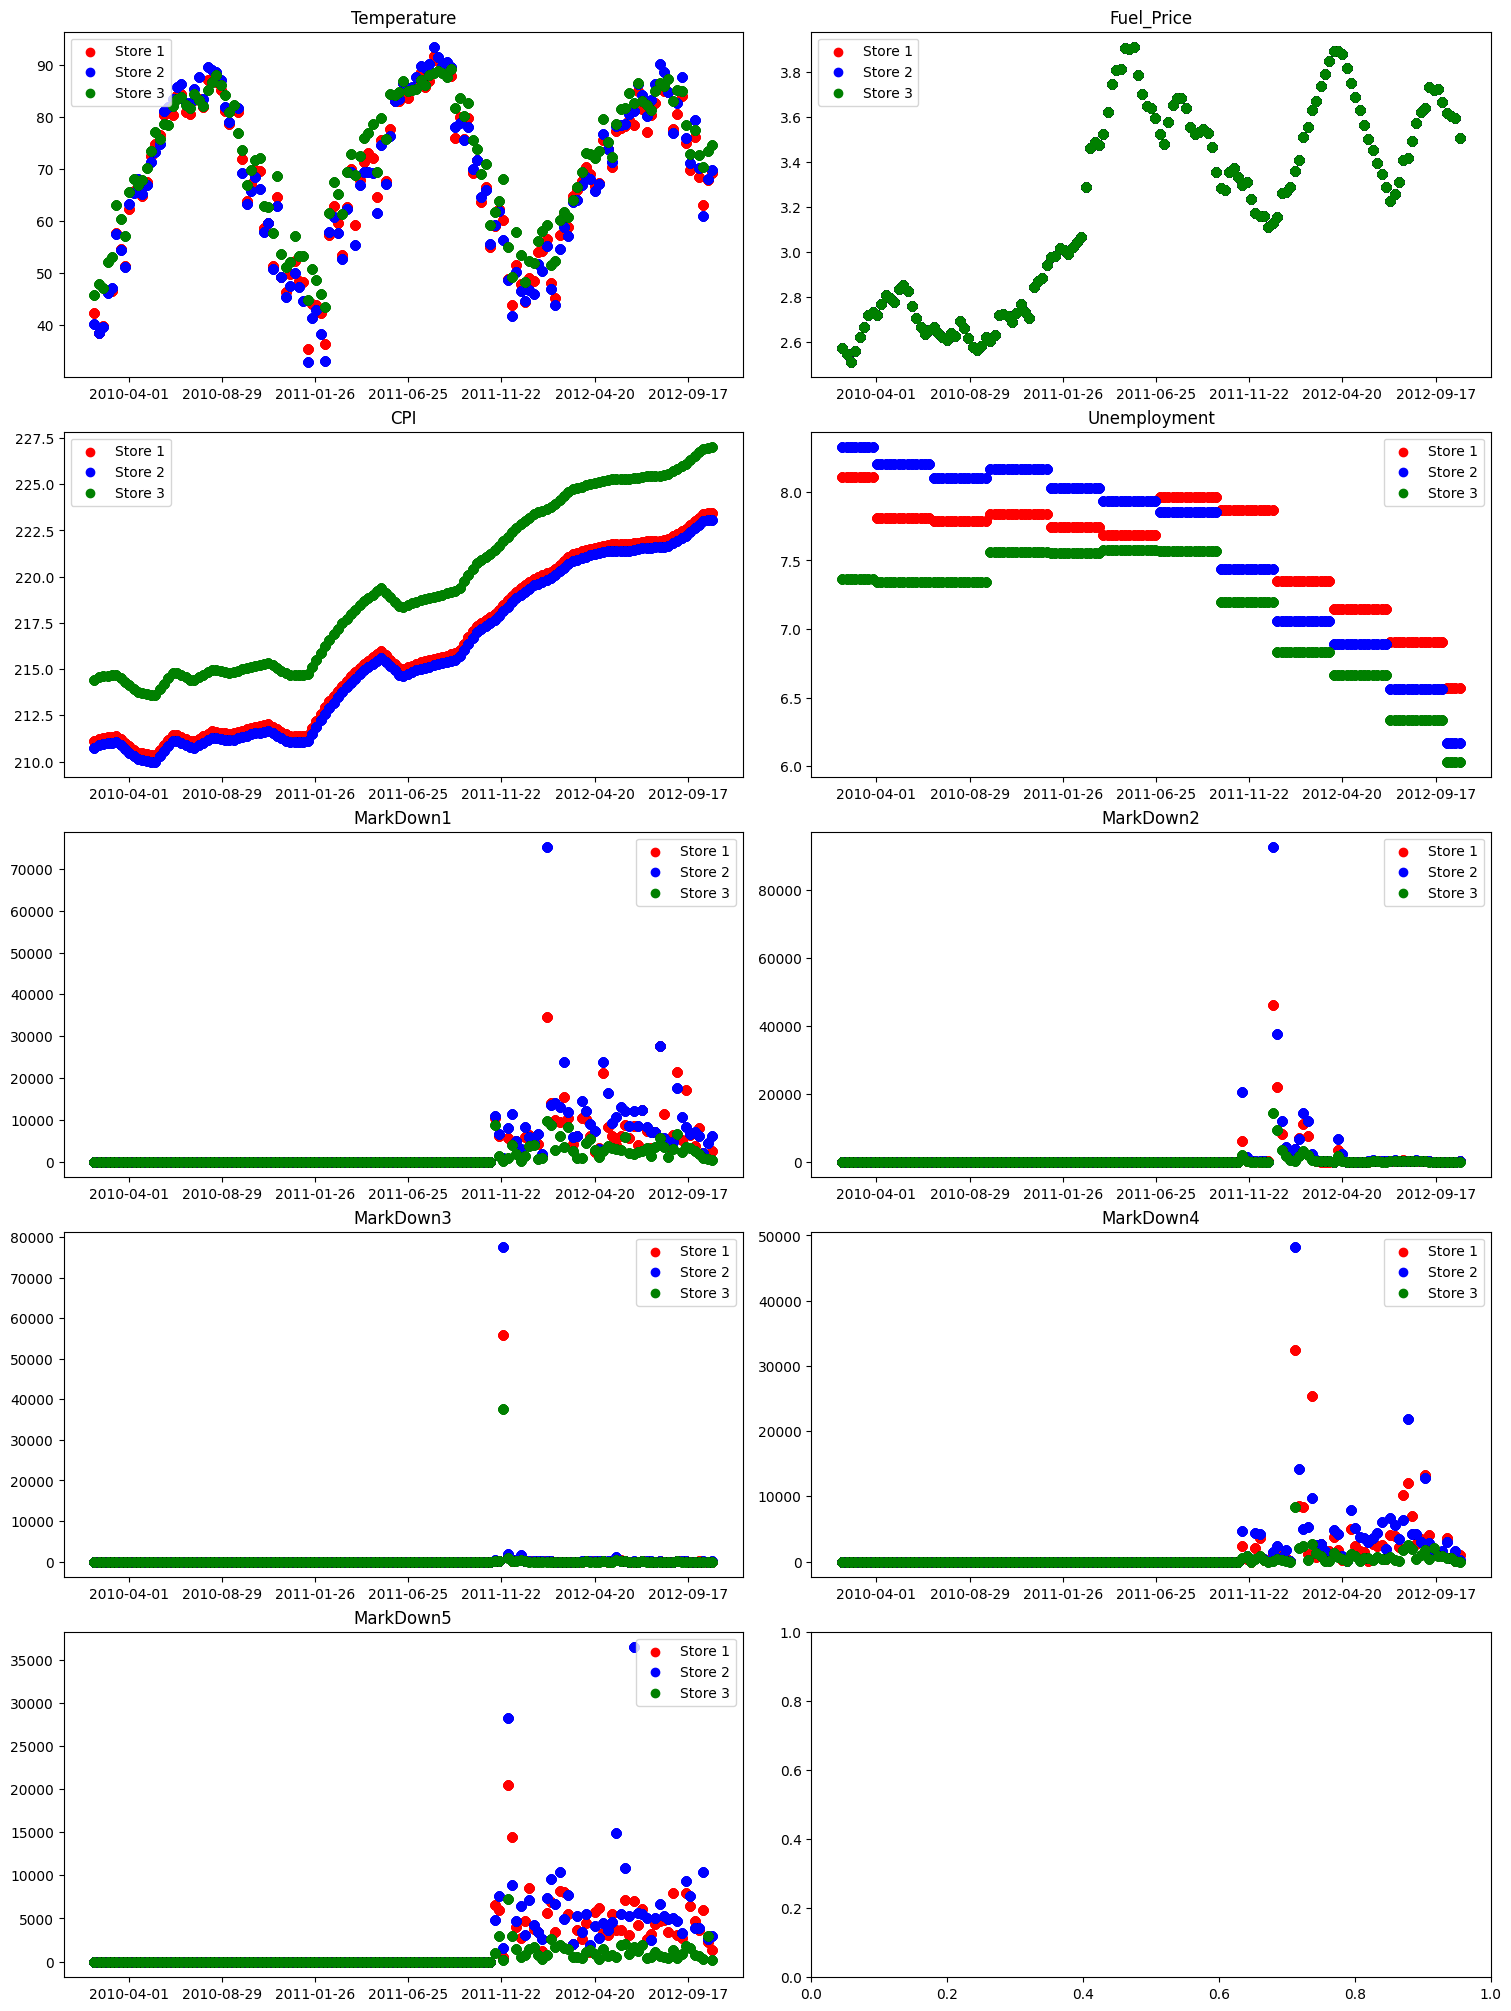

In [11]:
# Basic plots overview
selected_stores = merged_df['Store'].unique()[:3]

# Plots for the different features in the df:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
colors = {1: 'red', 2: 'blue', 3: 'green'}
for ax, feature in zip(axes.flatten(), features):
    for store in selected_stores:
        store_data = merged_df[merged_df['Store'] == store]
        ax.scatter(store_data['Date'], store_data[feature], label=f'Store {store}', color=colors[store])
    ax.set_title(feature)
    # Set equidistant x-axis ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    ax.legend()
plt.show()

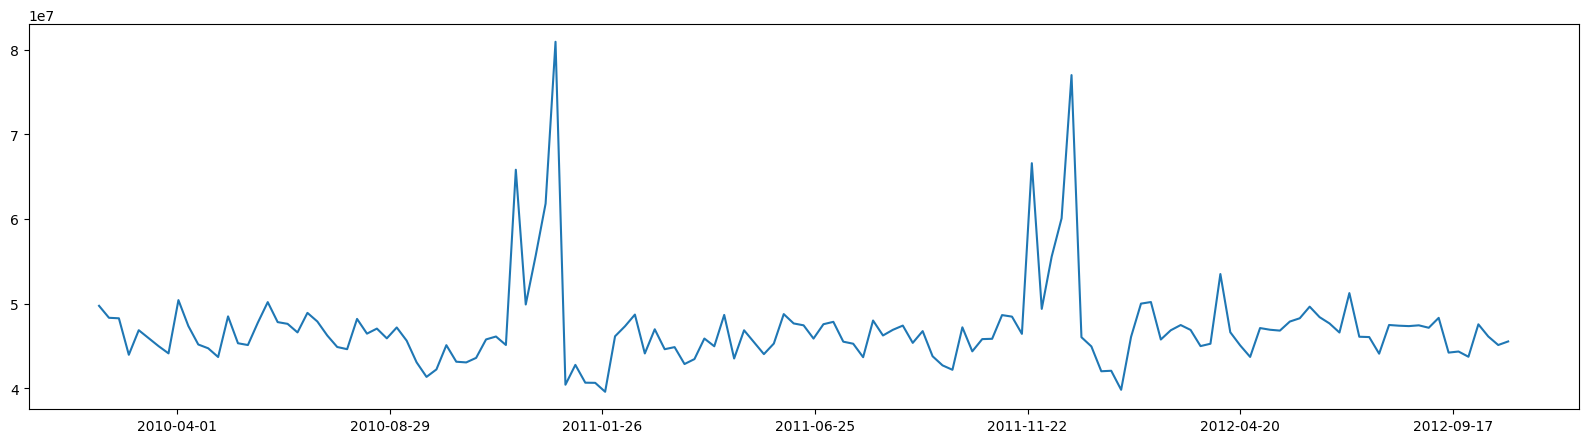

In [12]:
# Average weekly sales for the stores/departments during a week
df_average_sales_weekly = merged_df.groupby(by=["Date"], as_index = False)["Weekly_Sales"].sum()

df_average_sales = df_average_sales_weekly.sort_values("Weekly_Sales", ascending=False)

#print(df_average_sales[:10])

plt.figure(figsize=(20,5))
plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

### Taking into consideration seasonality by adding month variable

In [13]:
merged_df["month"] = merged_df['Date'].dt.month
merged_df = merged_df.drop(["Date"], axis=1)
merged_df = pd.get_dummies(merged_df, columns=["month"])#, prefix='month')
merged_df = pd.get_dummies(merged_df, columns=["Type"])


### Correlation plots

<Axes: >

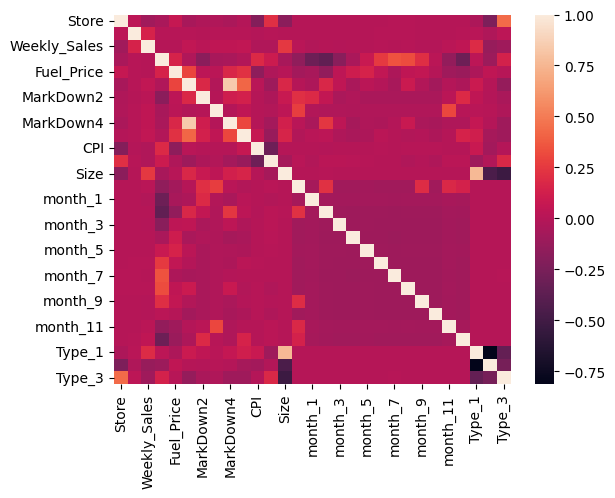

In [14]:
# Correlation between all features
sns.heatmap(merged_df.corr())


<Axes: >

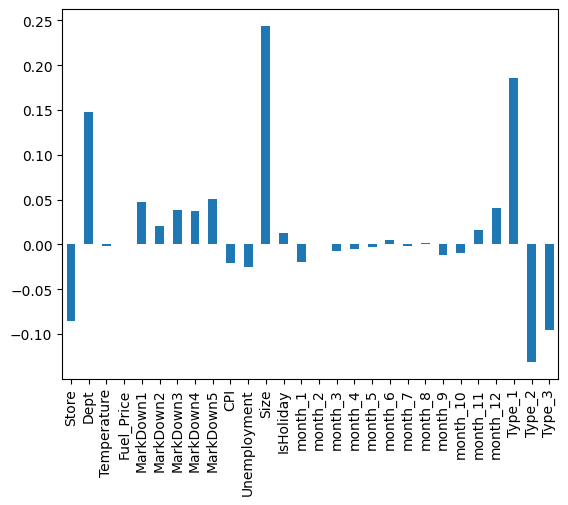

In [15]:
# Correlation between Weekly Sales and all other features
merged_df_corr = merged_df[merged_df.columns[:]].corr()['Weekly_Sales'][:]
merged_df_corr = merged_df_corr.drop("Weekly_Sales")
# Plot the correlation
merged_df_corr.plot.bar()

## Train & Test Data
### Methods:
- Linear regression
- random forest
- ExtraTree


In [16]:
# DF x & y

train_X = merged_df.drop(["Weekly_Sales"], axis=1)
train_y = merged_df["Weekly_Sales"]

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, shuffle=False, stratify=None)

### Linear regression

In [17]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
# Print out the MAE, MSE & RMSE
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 11900.68778496886
Mean Squared Error: 342169170.1627436
Root Mean Squared Error: 18497.815280803938
R2 Score: 0.05524492488188515


### Random Forest

In [18]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf.predict(X_test)

# Print out the MAE, MSE & RMSE for the Random Forest model
print('Random Forest Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('Random Forest Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_rf))
print('Random Forest Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('Random Forest R2 Score:', metrics.r2_score(y_test, y_pred_rf))

Random Forest Mean Absolute Error: 4494.513876602936
Random Forest Mean Squared Error: 88582606.05947311
Random Forest Root Mean Squared Error: 9411.833299600727
Random Forest R2 Score: 0.7554166946073151


In [ ]:
# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
gbr.fit(X_train, y_train)

# Predict on the test data
y_pred_gbr = gbr.predict(X_test)

# Print out the MAE, MSE & RMSE for the Gradient Boosting model
print('Gradient Boosting Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_gbr))
print('Gradient Boosting Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_gbr))
print('Gradient Boosting Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbr)))
print('Gradient Boosting R2 Score:', metrics.r2_score(y_test, y_pred_gbr))

Gradient Boosting Mean Absolute Error: 6256.422226578557
Gradient Boosting Mean Squared Error: 106517457.04025452
Gradient Boosting Root Mean Squared Error: 10320.7294819821
Gradient Boosting R2 Score: 0.7058972084492801


In [20]:
# Initialize the Extra Trees Regressor
#etr = ExtraTreesRegressor(n_estimators=50, max_depth=10, min_samples_split=10, random_state=42)
etr = ExtraTreesRegressor(
    n_estimators=100,  # More trees may improve performance
    max_depth=15,  # A higher max_depth may improve accuracy but increases computation
    min_samples_split=5,  # A lower value can allow more detailed splits
    random_state=42,
    n_jobs=-1  # Parallelize the training (use all available CPUs)
)
# Fit the model on the entire training data
etr.fit(X_train, y_train)

# Predict on the test data
y_pred_etr = etr.predict(X_test)

# Print out the MAE, MSE & RMSE for the Extra Trees model on the test data
print('Extra Trees Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_etr))
print('Extra Trees Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_etr))
print('Extra Trees Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_etr)))
print('Extra Trees R2 Score:', metrics.r2_score(y_test, y_pred_etr))

Extra Trees Mean Absolute Error: 4033.0202140883657
Extra Trees Mean Squared Error: 61900519.28620558
Extra Trees Root Mean Squared Error: 7867.688306370912
Extra Trees R2 Score: 0.8290879633595434


### Stacking method

In [ ]:


# Initialize the base models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)

# Initialize the Stacking Regressor with RandomForestRegressor as the final estimator
stacking_regressor = StackingRegressor(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        ('gbr', gbr),
        ('xgb', xgb)],
    final_estimator=LinearRegression()
)

# Fit the Stacking Regressor on the training data
stacking_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred_stacking = stacking_regressor.predict(X_test)

# Print out the MAE, MSE & RMSE for the Stacking Regressor on the test data
print('Stacking Regressor Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_stacking))
print('Stacking Regressor Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_stacking))
print('Stacking Regressor Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_stacking)))
print('Stacking Regressor R2 Score:', metrics.r2_score(y_test, y_pred_stacking))

: 